In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.data_loader import split_data
from utils.statistical_tests import find_cointegrated_pairs
from models.cointegrationModel import PartialCointegrationModel
from strategies.partial_cointegration_trading import PartialCointegrationTrader
from utils.visualization import plot_cointegration_trade

In [4]:
data_path = os.path.join("data", "jse_stocks.csv")
print(f"Chargement des données à partir de {data_path}...")

prices = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(prices.shape)

try:
    sector_path = os.path.join("data", "jse_sectors.csv")
    sectors_df = pd.read_csv(sector_path)
    sectors = dict(zip(sectors_df["Ticker"], sectors_df["Sector"]))
    print(f"Informations sectorielles chargées pour {len(sectors)} actions")
except:
    sectors = {}
    print("Informations sectorielles non disponibles")

Chargement des données à partir de data\jse_stocks.csv...
(6488, 29)
Informations sectorielles chargées pour 29 actions


In [5]:
train_data, test_data = split_data(prices, train_ratio=0.7)
print("\nRecherche de paires co-intégrées (cela peut prendre quelques minutes)...")
cointegrated_pairs = find_cointegrated_pairs(train_data, significance_level=0.05)

print(f"Trouvé {len(cointegrated_pairs)} paires co-intégrées sur toute la période disponible")



Recherche de paires co-intégrées (cela peut prendre quelques minutes)...
Trouvé 16 paires co-intégrées sur toute la période disponible



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000003)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non

Analyse de la paire 2: AMS.JO - MUR.JO (p-value: 0.006231)
  Secteurs: AMS.JO (Resources), MUR.JO (Construction)
  Même secteur: Non

Analyse de la paire 3: FSR.JO - DSY.JO (p-value: 0.007149)
  Secteurs: FSR.JO (Financials), DSY.JO (Financials)
  Même secteur: Oui

Analyse de la paire 4: AMS.JO - AEG.JO (p-value: 0.011182)
  Secteurs: AMS.JO (Resources), AEG.JO (Construction)
  Même secteur: Non

Analyse de la paire 5: SOL.JO - MTN.JO (p-value: 0.015214)
  Secteurs: SOL.JO (Resources), MTN.JO (Technology)
  Même secteur: Non


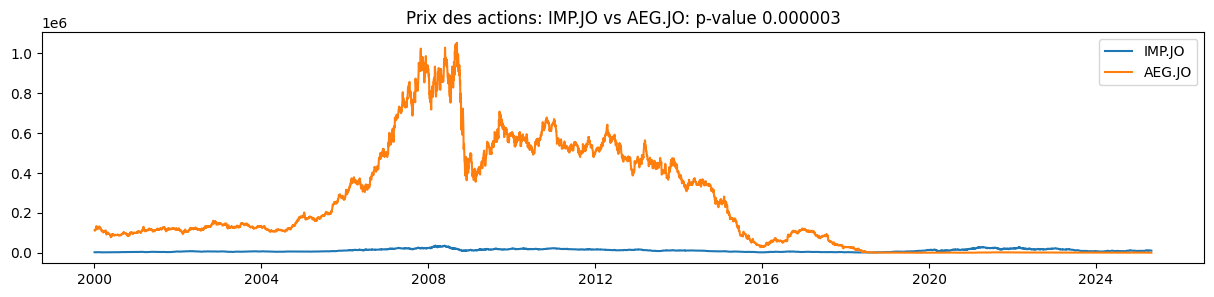

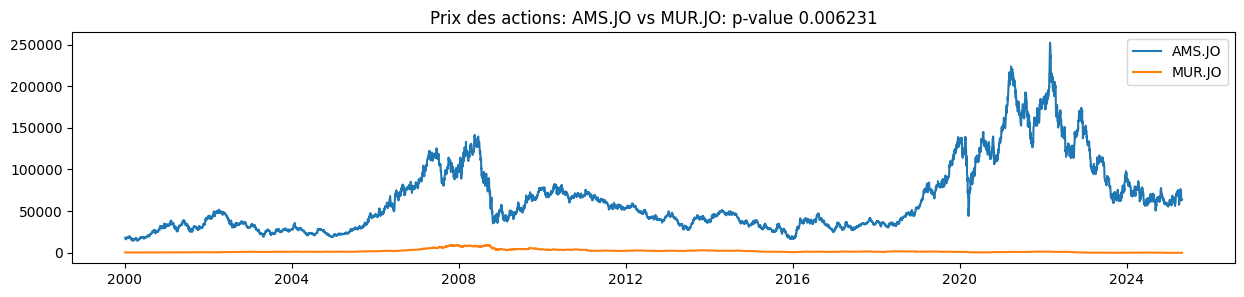

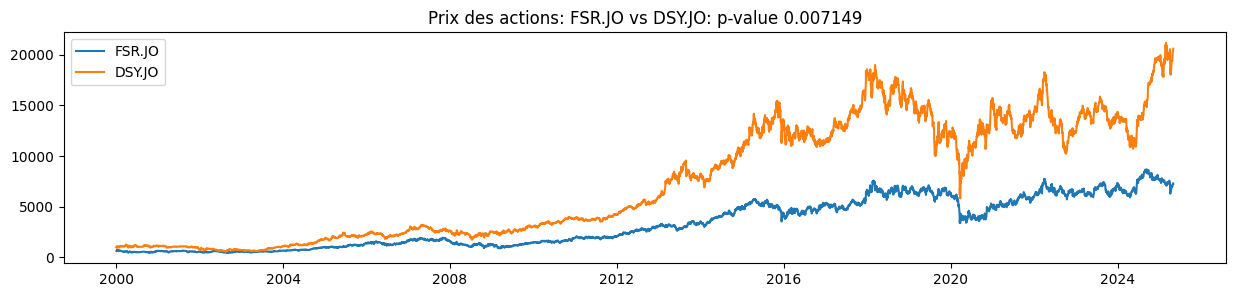

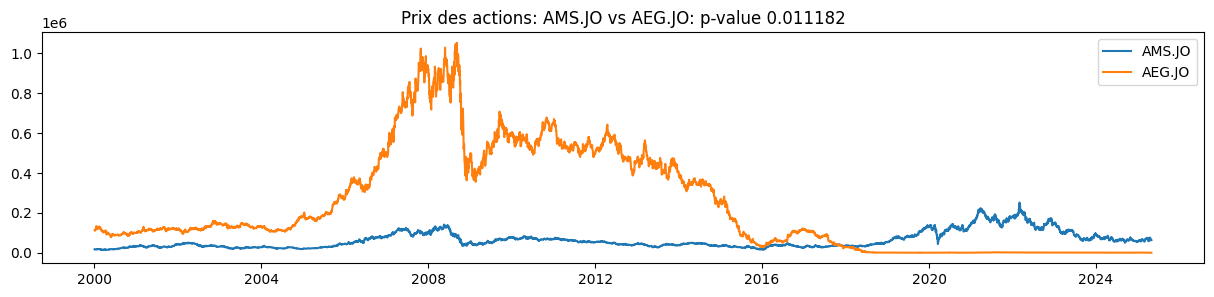

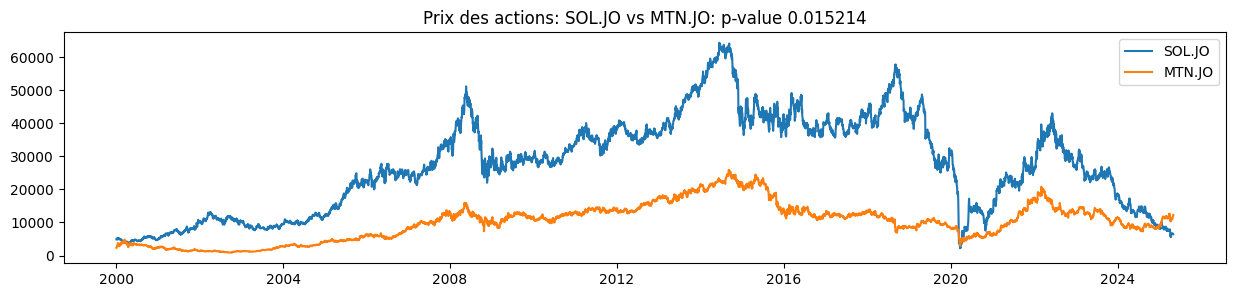

In [6]:
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = cointegrated_pairs[:5]
results = []

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})"
    )
    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    # Plot des prix, spread et résidus
    plt.figure(figsize=(15, 3))
    plt.plot(prices[ticker1], label=ticker1)
    plt.plot(prices[ticker2], label=ticker2)
    plt.title(f"Prix des actions: {ticker1} vs {ticker2}: p-value {p_value:.6f}")
    plt.legend()



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000003)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 13058.7168, Sharpe: 0.9865, Trades: 134


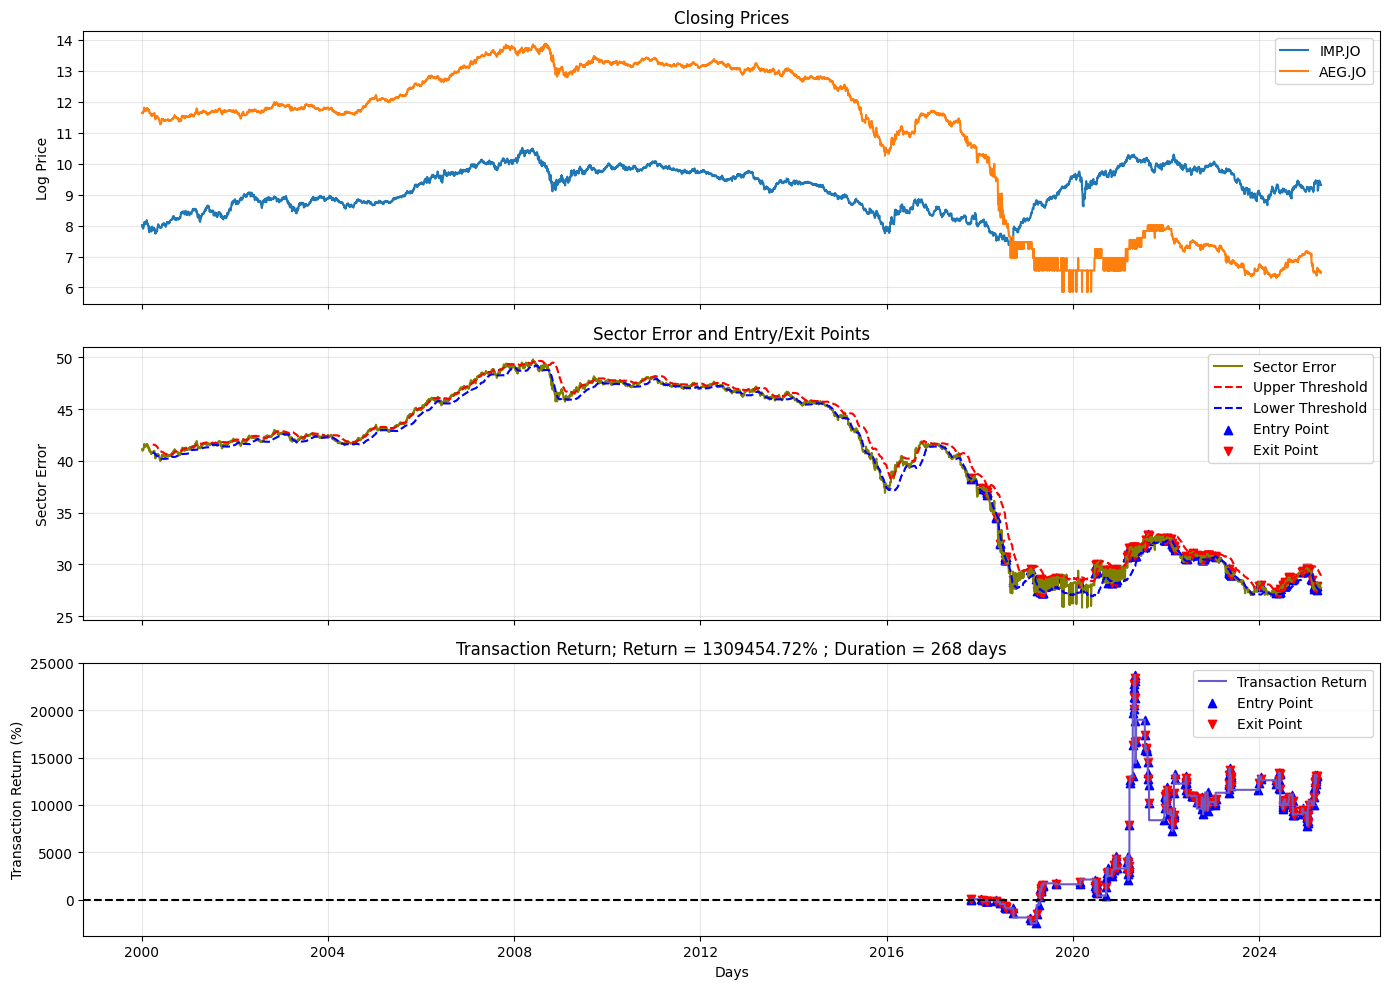


Analyse de la paire 2: AMS.JO - MUR.JO (p-value: 0.006231)
  Secteurs: AMS.JO (Resources), MUR.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: -110064.9393, Sharpe: -1.8403, Trades: 114


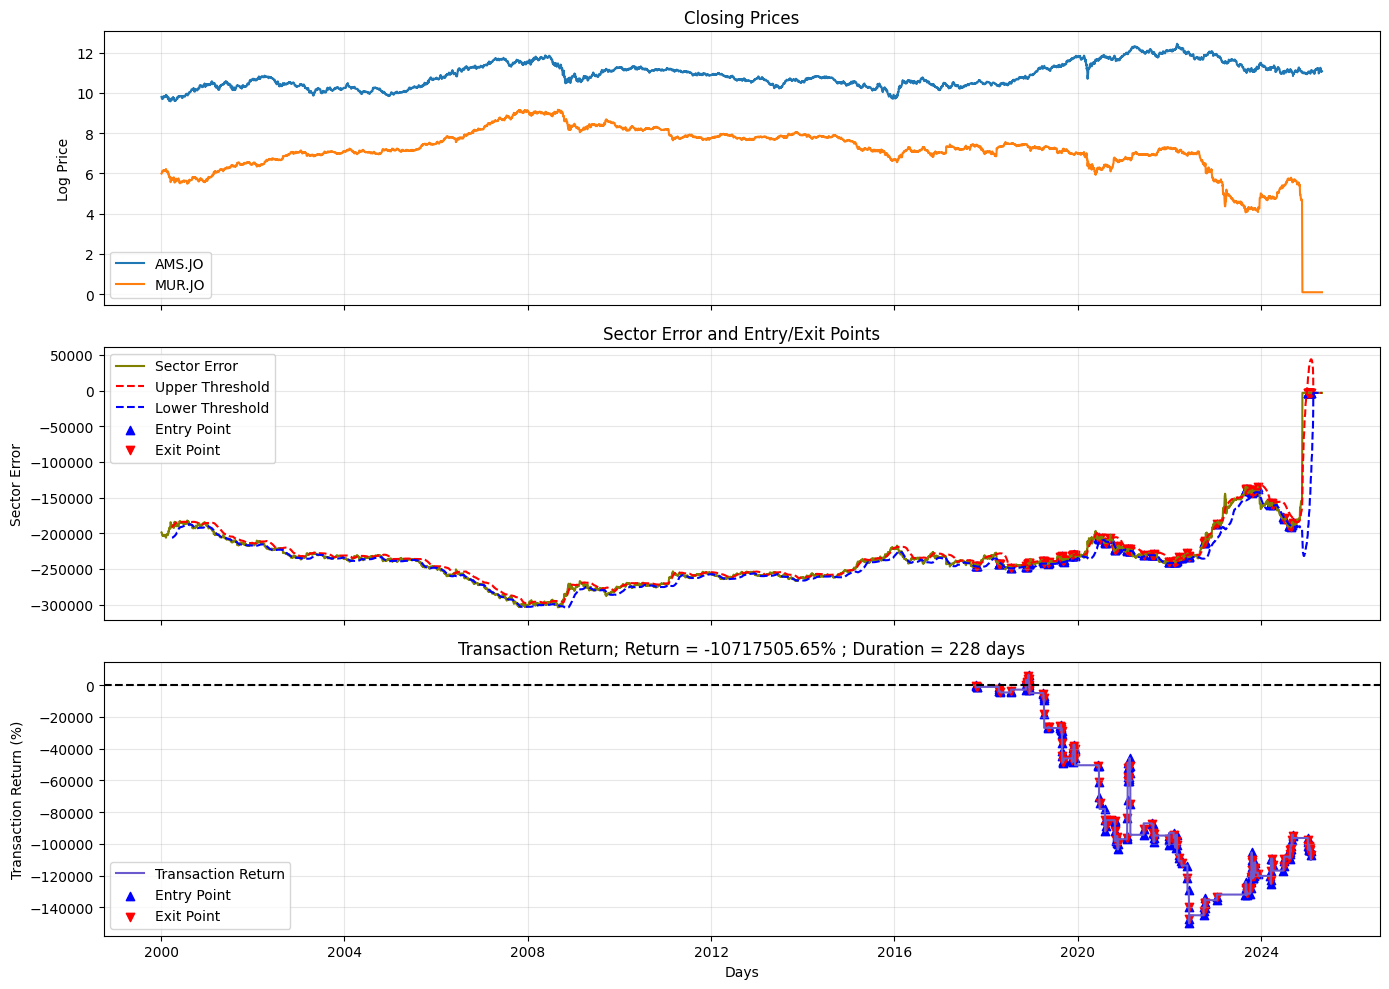


Analyse de la paire 3: FSR.JO - DSY.JO (p-value: 0.007149)
  Secteurs: FSR.JO (Financials), DSY.JO (Financials)
  Même secteur: Oui
  Performance: Rendement total: -1121.8521, Sharpe: -0.6424, Trades: 129


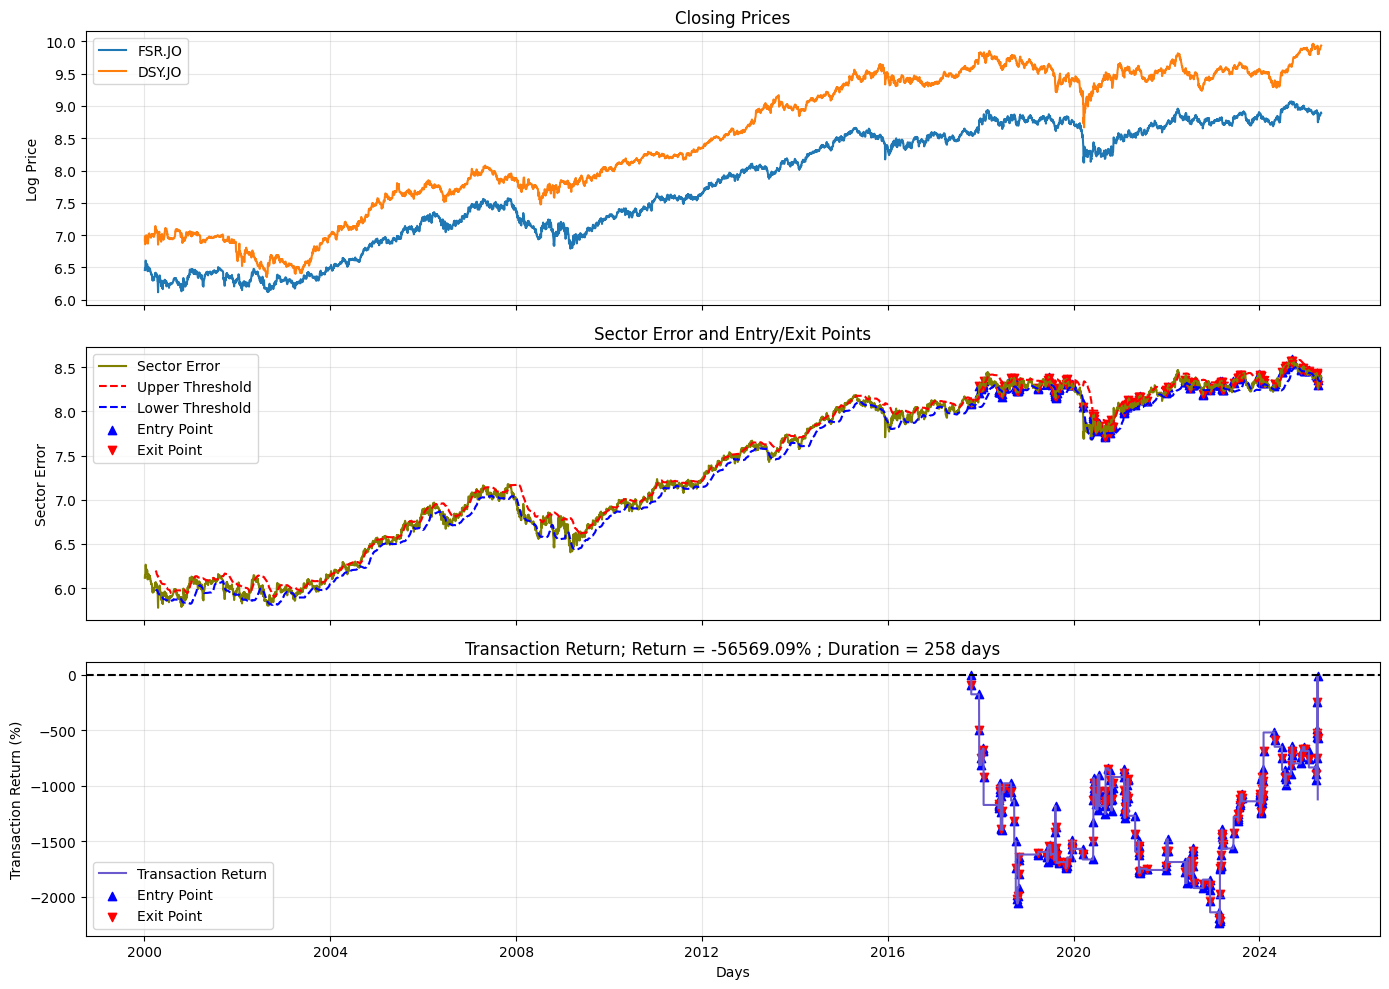


Analyse de la paire 4: AMS.JO - AEG.JO (p-value: 0.011182)
  Secteurs: AMS.JO (Resources), AEG.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 257882.8900, Sharpe: 2.5068, Trades: 155


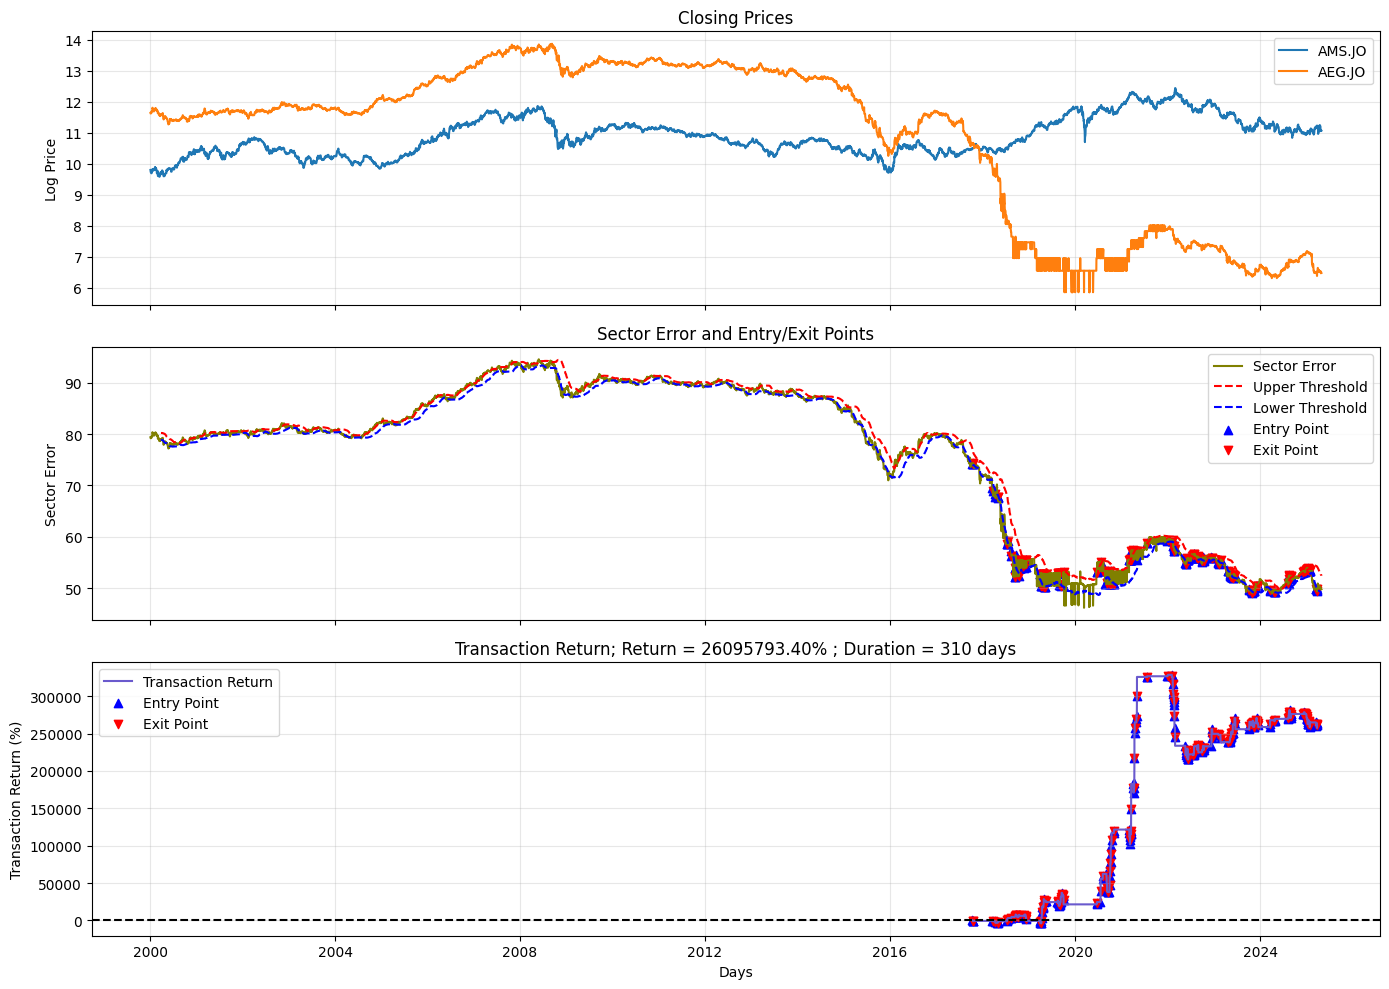


Analyse de la paire 5: SOL.JO - MTN.JO (p-value: 0.015214)
  Secteurs: SOL.JO (Resources), MTN.JO (Technology)
  Même secteur: Non
  Performance: Rendement total: 33103.7651, Sharpe: 2.1542, Trades: 180


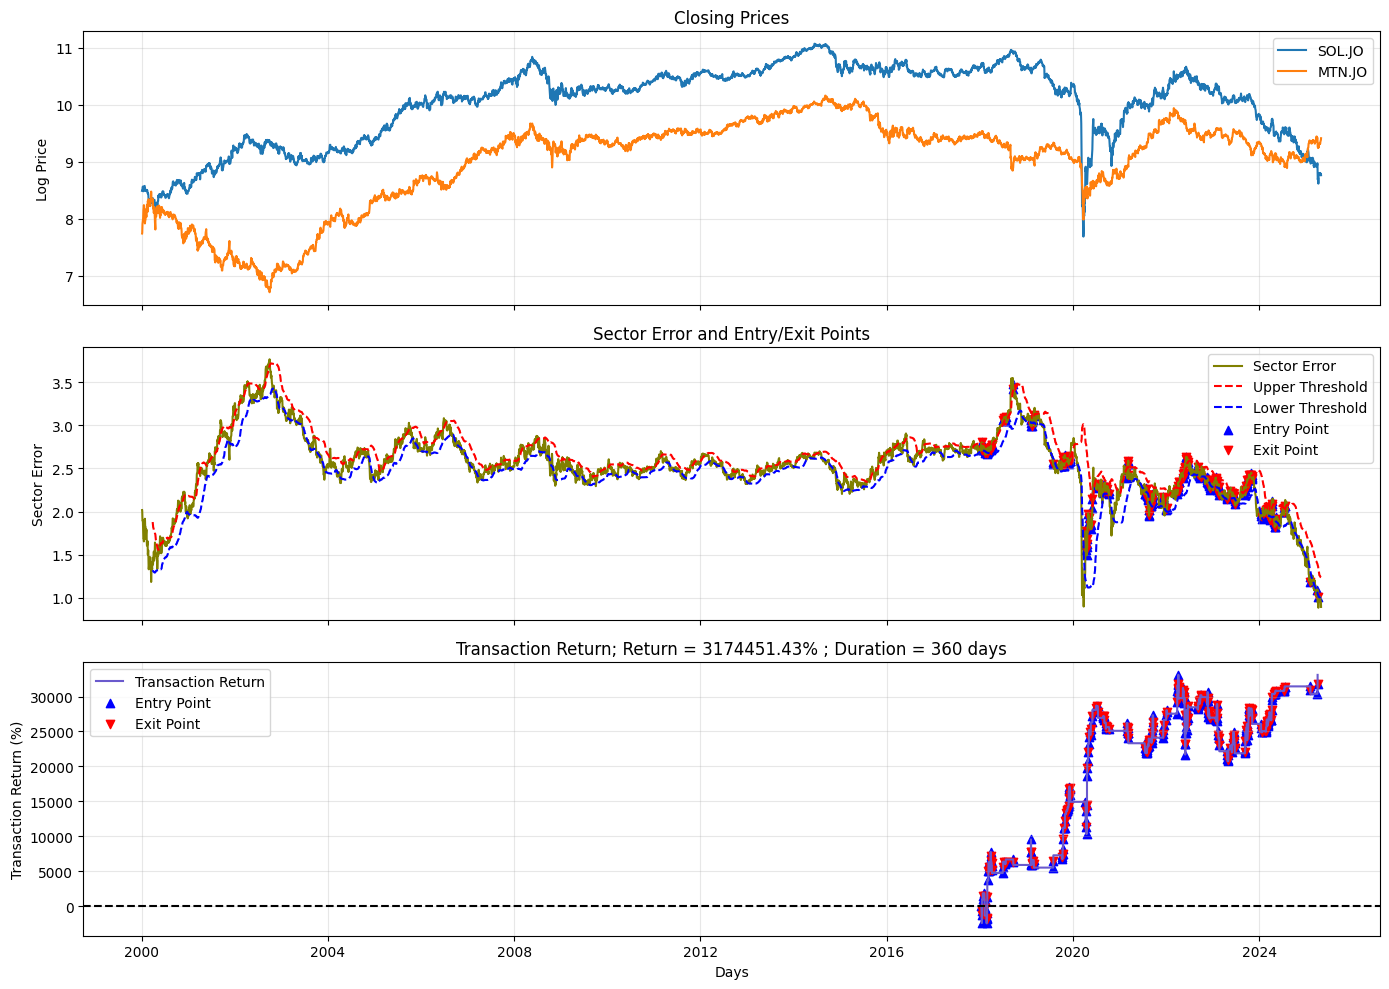

In [7]:
for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    model = PartialCointegrationModel(significance_level=0.05)
    trader = PartialCointegrationTrader(
        model,
        entry_threshold=1.25,  # Valeur optimale selon le document
        stop_loss=0.05,
        profit_target=0.05,
        rolling_window=60,
        kalman_gain=0.7  # Valeur optimale selon le document
    )

    trades = trader.run_backtest(
        test_data[ticker1], test_data[ticker2]
    )

    if trades.empty:
        print("    Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trader.trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values
    sharpe = (
        np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
        if len(pnl_values) >= 2 and np.std(pnl_values) > 0
        else 0
    )

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Rho": model.rho,  # Spécifique à la cointégration partielle
            "Kalman_Gain": model.kalman_gain,  # Spécifique à la cointégration partielle
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )
    
    plot_cointegration_trade(
        prices=prices,
        ticker1=ticker1,
        ticker2=ticker2,
        trades=trades,
        beta=model.beta,
        entry_threshold=1.25  # Valeur optimale pour la cointégration partielle
    )


In [8]:
for i, (ticker1, ticker2, p_value) in enumerate(cointegrated_pairs):
    model = PartialCointegrationModel(significance_level=0.05)
    trader = PartialCointegrationTrader(
        model,
        entry_threshold=1.25,
        stop_loss=0.05,
        profit_target=0.05,
        rolling_window=60,
        kalman_gain=0.7
    )

    trades = trader.run_backtest(
            test_data[ticker1],
            test_data[ticker2],
        )
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")


    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Rho": model.rho,
            "Kalman_Gain": model.kalman_gain,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )


Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000003)
  Performance: Rendement total: 13058.7168, Sharpe: 0.9865, Trades: 402

Analyse de la paire 2: AMS.JO - MUR.JO (p-value: 0.006231)
  Performance: Rendement total: -110064.9393, Sharpe: -1.8403, Trades: 342

Analyse de la paire 3: FSR.JO - DSY.JO (p-value: 0.007149)
  Performance: Rendement total: -1121.8521, Sharpe: -0.6424, Trades: 387

Analyse de la paire 4: AMS.JO - AEG.JO (p-value: 0.011182)
  Performance: Rendement total: 257882.8900, Sharpe: 2.5068, Trades: 465

Analyse de la paire 5: SOL.JO - MTN.JO (p-value: 0.015214)
  Performance: Rendement total: 33103.7651, Sharpe: 2.1542, Trades: 540

Analyse de la paire 6: IMP.JO - MUR.JO (p-value: 0.021000)
  Performance: Rendement total: -14724.5785, Sharpe: -1.4686, Trades: 504

Analyse de la paire 7: MRP.JO - APN.JO (p-value: 0.024227)
  Performance: Rendement total: -3160.2787, Sharpe: -0.3606, Trades: 441

Analyse de la paire 8: NTC.JO - APN.JO (p-value: 0.026272)
  Perfor

In [9]:
total_pnl = sum([result["Total_Return"] for result in results])
mean_pnl = np.mean([result["Mean_PnL"] for result in results])
print(f"\nRendement total de toutes les paires: {total_pnl:.4f}")
print(f"Rendement moyen de toutes les paires: {mean_pnl:.4f}")


Rendement total de toutes les paires: 361075.3858
Rendement moyen de toutes les paires: 28.3620
